# II. Ensembles

В задачах нужно корректно реализовать функции, чтобы проходили тесты. 

## 1. Bootstrap.

### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать псевдовыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$

На вход массив чисел $X$ и число бутстрепных выборок $B$. Необходимо реализовать свой бутстреп и найти матожидание и стандартную ошибку у бутстрепных выборок.


### TASK

In [1]:
import numpy as np
import random
from scipy.stats import sem # ищет SE среднего
def random_shuffle(X,N):
    S = []
    for i in range(N):
        j = random.randint(0,len(X)-1)
        S.append(X[j])
    return S
        
def get_stats(X: np.array, B:int)->tuple:
    SE = 0
    mean = 0
    for i in range(B):
        X_new = random_shuffle(X,len(X))
        SE+=sem(X_new)
        mean+= np.array(X_new).mean()
    mean = mean/B
    SE = SE/B
    return mean, SE

### Open tests

In [2]:
######################################################
X = np.array([37,43,38,36,17,40,40,45,41,84])
B = 100000

mean, se = get_stats(X, B)

assert np.abs(mean - 42.1) < 0.05
assert np.abs(se - 4.56) < 0.03
######################################################

# 2. Bagging

Необходимо реализовать свой небольшой беггинг на деревьях заданной грубины

* бустингом сделать несколько выборок $X_1, \ldots, X_B$
* обучить на этих выборках алгоритмы: $a_1(\cdot), \ldots, a_B(\cdot)$

Получить результат беггинга как:
$$a(x) = \frac{1}{B}\sum_{b=1}^{B}a_b(x)$$


# TASK

In [3]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeRegressor as DTR
np.random.seed(42)
def bagging(X_train, y_train, X_test, boot_count, depth):
    estimators = np.array([DTR(max_depth=depth) for _ in range(boot_count)])
    y_pred_array = np.array([0.]*len(X_test))
    for estimator in estimators:
        indices = np.random.randint(0,len(X_train)-1,size = boot_count)
        estimator.fit(X_train[indices], y_train[indices])
        y_pred_array = np.column_stack([y_pred_array, estimator.predict(X_test)])
    y_pred = np.mean(y_pred_array[:,1:], axis = 1) 

    return y_pred

In [25]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

######################################################

X_train = np.array([[0, 0], [1, 1], [5, 5], [8, 8], [10, 10]])
y_train = np.array([0, 1, 5, 8, 10])
X_test  = np.array([[4, 4], [6, 6]])
y_test  = np.array([4, 6])

B = 1000

y_pred = bagging(X_train, y_train, X_test, boot_count=B, depth=3)

assert_array_almost_equal(y_pred, np.array([4, 6]), decimal=0)

######################################################

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=124,
                                                    shuffle=True)


y_pred = bagging(X_train, y_train, X_test, boot_count=200, depth=10)

y_dt_pred = DTR().fit(X_train, y_train).predict(X_test)
y = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

print(mean_squared_error(y, y_test))
print(mean_squared_error(y_dt_pred, y_test))
print(mean_squared_error(y_pred, y_test))
assert mean_squared_error(y_pred, y_test) < 15

12.22846135526315
30.094078947368416
13.494927418069569


## 3. X-regression

Необходимо найти наилучшие параметры для XGBRegression, обучить модель и вернуть ее. Данные берутся из папки data.

Сам гридсерч или нативное исследование необходимо делать вне функции обработки, чтобы не получить TL.

### TASK

In [26]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
def xreg(X_train: np.array, y_train:np.array) -> XGBRegressor:
    parameters = {
              'learning_rate': [0.05,0.1],
              'max_depth': range(1,5),
              'min_child_weight': range(3,5),
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [10], 
              'missing':[-999],
              'seed': [1337]} 
    x_regr = GridSearchCV(XGBRegressor(),parameters,cv = 5)
    x_regr.fit(X_train,y_train)
    model = x_regr.best_estimator_
    return model

### OPEN TESTS

In [27]:
import pandas as pd
import time
df = pd.read_csv('data/Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
t1 = time.time()
xgb_model = xreg(X_train, y_train)
t2 = time.time()

assert t2 - t1 < 10

y_pred = xgb_model.predict(X_test)

assert type(xgb_model) == xgb.sklearn.XGBRegressor
assert mean_squared_error(y_pred, y_test) < 3
print('Well Done')

Well Done


## 4. CatFeatures

Обучите модель классификации катбуста на предложенных данных и верните обученную модель. 

Воспользуйтесь встроенной обработкой категориальных признаков. Не забудьте обработать Nan значения.

In [28]:
!pip install catboost

     |████████████████████████████████| 66.2MB 63kB/s 


### TASK

In [29]:
import catboost
def catfeatures(df: pd.DataFrame):
    df['dep_delayed_15min'] = df['dep_delayed_15min'].apply(lambda x: 1 if x=='Y' else 0)
    y_train = df['dep_delayed_15min']
    X_train = df.drop(['dep_delayed_15min','DepTime'], axis = 1)
    params = {'cat_features' : ['Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest'],
    "iterations": 250, 
    "learning_rate": 0.1, 
    "depth": 10, 
    "min_data_in_leaf": 10,
    "silent" : True
}
    model  = catboost.CatBoostClassifier(**params)
    model.fit(X_train,y_train)
    return model

### TESTS

In [30]:
from sklearn.metrics import accuracy_score
df = pd.read_csv('data/flight_delays_train.csv')
df_train = df[:7000]

t1 = time.time()
model = catfeatures(df_train)
t2 = time.time()

assert t2 - t1 < 10
assert type(model) == catboost.CatBoostClassifier

df_test = pd.read_csv('data/flight_catfeature_test.csv')
df_test['dep_delayed_15min'] = df_test['dep_delayed_15min'].apply(lambda x: 1 if x=='Y' else 0)
df_test = df_test.drop('Unnamed: 0', axis=1)
X_test = df_test.drop(['dep_delayed_15min','DepTime'],axis=1)
y_test = df_test['dep_delayed_15min']

y_pred = model.predict(X_test)

assert accuracy_score(y_test, y_pred) > 0.80 
print('Well Done')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Well Done


## 5. Производные для регрессии

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### TASK

In [37]:
def init(y_i: np.array) -> float:
    f_0 = y_i.mean()
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    g = -2*(a - y)
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    alpha = np.sum((y - f)*b)/np.sum(b**2)
    return alpha

### TESTS

In [40]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - (0.2)) < 1e-9
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al - (0.2748)) < 1e-2
print('Well Done!')

Well Done!


## 6. GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### TASK

In [41]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        
    def fit(self, X_train: np.array, y_train: np.array): 
        self.f_list.append(np.array([init(y_train)]*len(y_train)))
        for t in range(self.n_estimators):
            a = self.f_list[t].copy()
             
            g = grad(a,y_train)
            self.g_list.append(g)

            b_t = self.estimators_[t].fit(X_train,self.g_list[t])
            b = np.array(b_t.predict(X_train))
            self.b_list.append(b)
            
  
            self.alpha.append(alpha(a,self.b_list[t],y_train))

            a+= alpha(a,self.b_list[t],y_train)*b
            self.f_list.append(a)
        return self
        
    def predict(self, X_test) -> np.array:
        y_pred = np.array([self.f_list[0][0]]*(X_test.shape[0]))

        for i in range(self.n_estimators):
           y_pred+= np.array(self.alpha[i])*np.array(self.estimators_[i].predict(X_test))
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        return mean_squared_error(self.predict(X_test), y_test)

### TESTS

In [43]:
n_estimators = 2
max_depth = 3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.025


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.017
print('Well Done')

Well Done


# Самопроверка

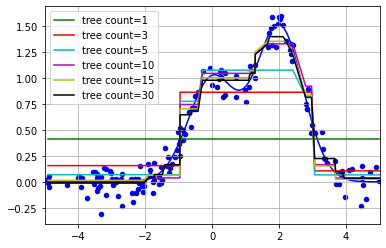

In [44]:
import matplotlib.pyplot as plt
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()



model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()